In [1]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision


from torch.optim import lr_scheduler

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 

In [3]:
class MyModel(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            # First convolution Layer
            # input size = (32, 32), output size = (28, 28)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Second convolution Layer
            # input size = (28, 28), output size = (24, 24)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # After mac pool output size = (12, 12)
            nn.MaxPool2d(kernel_size=2),
            
            # Third convolution layer
            # input size = (12, 12), output size = (10, 10)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # after max pool output size = (5, 5)
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(dropout),
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weight in last conv layer = 64 * 5 * 5
            nn.Linear(in_features=256 * 5 * 5, out_features=2048), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            # second fully connected layer
            # in_features = output of last linear layer = 800
            nn.Linear(in_features=2048, out_features=512),             
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            # Fouth fully connected layer, number of classes = 10
            nn.Linear(in_features=512, out_features=10)
            
        )
        
    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        # apply classification head
        x = self._head(x)
        
        return x



In [4]:
my_model = MyModel()

In [5]:
def get_mean_std_train_data(data_root):
    
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.CIFAR10(root=data_root, train=True, download=False, transform=train_transform)
    
    # return mean (numpy.ndarray) and std (numpy.ndarray)
    mean = np.array([train_set.data[:, :, :, 0].mean()/255, train_set.data[:, :, :, 1].mean()/255, train_set.data[:, :, :, 2].mean()/255]) 
    std = np.array([train_set.data[:, :, :, 0].std()/255, train_set.data[:, :, :, 1].std()/255, train_set.data[:, :, :, 2].std()/255])
    return mean, std


In [6]:
def get_data(batch_size, data_root, num_workers=1):
    
    
    try:
        mean, std = get_mean_std_train_data(data_root)
        assert len(mean) == len(std) == 3
    except:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        
    
    train_test_transforms = transforms.Compose([
        # this re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean and divide by variance.
        transforms.Normalize(mean, std)
    ])
    
    train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Grayscale(3),
    ]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=data_root, train=True, download=False, transform=train_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=data_root, train=False, download=False, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

In [7]:
# @dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [8]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 50  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.02  # determines the speed of network's weights update
        
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "../resource/lib/publicdata/images"  # folder to save data
    num_workers: int = 10  # number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.

In [9]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [10]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        #if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
        #    print(
        #        'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
        #            epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
        #        )
        #    )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

In [11]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

In [12]:
def save_model(model, device, model_dir='models', model_file_name='cifar10_cnn_model.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

In [13]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    best_accuracy = torch.tensor(0)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )


        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)

            if scheduler is not None:
                scheduler.step()
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
            
            if current_accuracy > best_accuracy:
                best_accuracy = current_accuracy
                print('Accuracy improved, saving the model.\n')
                save_model(model, device)
            
                
    print("Total time: {:.2f}, Best Loss: {:.3f}, Best Accuracy: {:.3f}".format(time.time() - t_begin, best_loss, 
                                                                                best_accuracy))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [14]:


model = MyModel(0.2)

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    momentum = 0.7
)

lmbda = lambda epoch: 1/(1 +  epoch)
# Scheduler
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)

model, train_loss_plateau, train_acc_plateau, test_loss_plateau, test_acc_plateau = main(
    model, 
    optimizer, 
    scheduler)



Elapsed 19.59s, 19.59 s/epoch, 0.01 s/batch, ets 960.05s

Test set: Average loss: 1.2986, Accuracy: 5417/10000 (54%)

Accuracy improved, saving the model.

Elapsed 37.84s, 18.92 s/epoch, 0.01 s/batch, ets 908.08s

Test set: Average loss: 0.9598, Accuracy: 6569/10000 (66%)

Accuracy improved, saving the model.

Elapsed 55.50s, 18.50 s/epoch, 0.01 s/batch, ets 869.57s

Test set: Average loss: 0.8448, Accuracy: 7019/10000 (70%)

Accuracy improved, saving the model.

Elapsed 72.62s, 18.16 s/epoch, 0.01 s/batch, ets 835.15s

Test set: Average loss: 0.7881, Accuracy: 7229/10000 (72%)

Accuracy improved, saving the model.

Elapsed 88.70s, 17.74 s/epoch, 0.01 s/batch, ets 798.31s

Test set: Average loss: 0.7135, Accuracy: 7518/10000 (75%)

Accuracy improved, saving the model.

Elapsed 104.83s, 17.47 s/epoch, 0.01 s/batch, ets 768.78s

Test set: Average loss: 0.6768, Accuracy: 7652/10000 (77%)

Accuracy improved, saving the model.

Elapsed 120.97s, 17.28 s/epoch, 0.01 s/batch, ets 743.08s

Test

In [18]:
import matplotlib.pyplot as plt

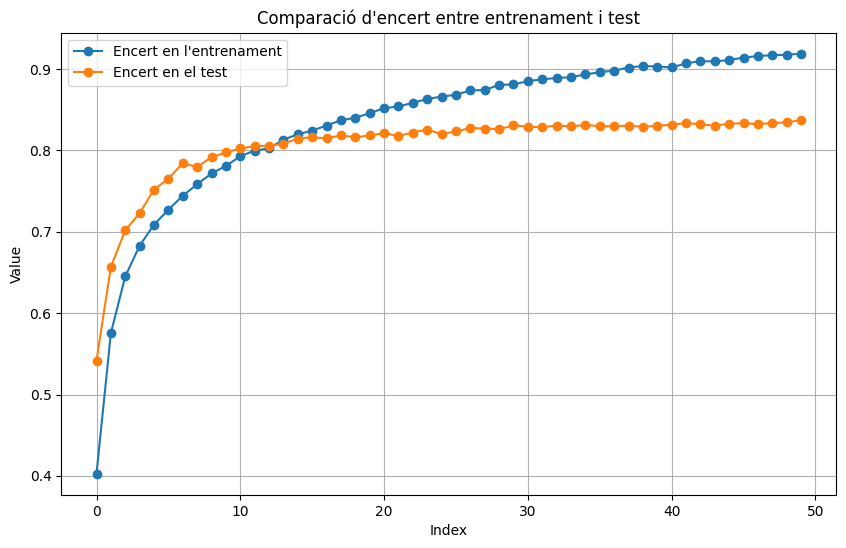

In [22]:
plt.figure(figsize=(10,6))

plt.plot(train_acc_plateau, label="Encert en l'entrenament", marker='o')
plt.plot(test_acc_plateau, label='Encert en el test', marker='o')

plt.title("Comparació d'encert entre entrenament i test")
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
cnn_model = MyModel()

model_path = 'cifar10_cnn_model.pt'
cnn_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
def prediction(model, train_config, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(train_config.device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(train_config.device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [17]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"
    
    

# load test data without image transformation
test = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=train_config.data_root, train=False, download=False, 
                   transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

try:
    mean, std = get_mean_std_train_data(data_root)
    assert len(mean) == len(std) == 3
except:
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)

# load testdata with image transformation
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=train_config.data_root, train=False, download=False, transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    # pass the loaded model
    pred, prob = prediction(cnn_model, train_config, data)
    break
    

plt.rcParams["figure.figsize"] = (3, 3)
for images, label in test:
    for i, img in enumerate(images):   
        print('Pred: {0}({1:0.2}), Label: {2}'.format(classes[pred[i]], prob[i], classes[label[i]]))
    break

Pred: cat(0.86), Label: cat
Pred: ship(0.98), Label: ship
Pred: ship(0.52), Label: ship
Pred: plane(0.93), Label: plane
Pred: frog(0.81), Label: frog
